## Identifying Places of Interest in Ulaanbaatar, Mongolia

The places of interest considered for the analysis are:
- hospital
- dentist
- doctor
- restaurant
- cafe 
- school
- bank
- pharmacy
- park

### Importing required packages

In [2]:
import pandas as pd
import requests
import numpy as np
import geopandas as gpd
import time
from shapely.geometry import Point
import pylab as pl
%pylab inline

from API_keys import get_key
import argparse
import json
import pprint
import requests
import sys
import urllib
import geocoder
from pandana.loaders import osm
from shapely.geometry import Point
import mplleaflet as mpll


try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

Populating the interactive namespace from numpy and matplotlib


### Google Maps Places API

The Places API from Google Maps is a service that returns information about places using HTTP requests. Places are defined within this API as establishments, geographic locations, or prominent points of interest.

Since we need geographic information as well along with our points of interest, we'll be using 'Place Seach' API.

In [7]:
def get_APIdata(key, place = 'Ulaanbaatar', radius=25000, category = 'establishment', strictbound=True):
    
    """
    This function looks for places of interest in given city and returns it in json format.
    
    
    Inputs:
    
    key: Google API Key
    
    place: str: Name of the city or area of interest
    
    radius: int: A circular buffer to limit the result. Default set to 100000m (100km)
    
    category: str: establishment or geocode
    
    // establishment returns only businessnes
    
    strictbound: bool: Hard restriction on radius for data search
    
    
    Returns:
    Json dump
    
    """
    amenities = ['hospital', 'dentist', 'doctor', 'restaurant','cafe','school','bank','pharmacy','park']
    
    country = geocoder.arcgis("{}".format(place))
    
    lat = country.geojson['features'][0]['geometry']['coordinates'][1]
    lon = country.geojson['features'][0]['geometry']['coordinates'][0]
    
    pt1 = ((country.geojson['features'][0]['bbox'][0] + lon)/2, (country.geojson['features'][0]['bbox'][1] + lat)/2)
    pt2 = ((country.geojson['features'][0]['bbox'][2] + lon)/2, (country.geojson['features'][0]['bbox'][3] + lat)/2)
    pt3 = ((country.geojson['features'][0]['bbox'][0] + lon)/2, (country.geojson['features'][0]['bbox'][3] + lat)/2)
    pt4 = ((country.geojson['features'][0]['bbox'][2] + lon)/2, (country.geojson['features'][0]['bbox'][1] + lat)/2)
    pt5 = (lon, lat)
    
    points = [pt1, pt2, pt3, pt4, pt5]
    
    place_list = []
    
    for j in points:
        for i in amenities:
            link = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={y},{x}\
            &radius={rad}&type={string}&key={key}".format(y=j[1], x=j[0], rad=radius, string=i, key=key)


            response = requests.request('GET', link)
            response = response.json()
            
            place_list.append(response)
            
            time.sleep(5)

            tokens = []

            try:
                tokens.append(response['next_page_token'])

                try:
                    while response['next_page_token'] != '':
                        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?pagetoken={pgtoken}&key={key}".format\
                        (pgtoken= response['next_page_token'], key = key)

                        response = requests.request('GET', url)
                        response = response.json()

                        #req = places.nearby_search(keyword='school', lat_lng={'lat':47.922150000000045, 'lng':106.91767000000004}, 
                        #                       radius=10000, pagetoken= req.raw_response['next_page_token'])

                        tokens.append(response['next_page_token'])
                        place_list.append(response)
                        time.sleep(5)

                except KeyError:
                    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?pagetoken={pgtoken}&key={key}".format\
                        (pgtoken = tokens[-1] , key = key)

                    response = requests.request('GET', url)
                    response = response.json()
                    place_list.append(response)
                    time.sleep(5)

            except KeyError:
                pass
            #res_list.append(response.json())
        
    ##### Required only if using 'Autocomplete API' #######
    #string=None
    #session_id = np.random.randint(1,99999999)
    #if strictbound:
    #    url = "https://maps.googleapis.com/maps/api/place/autocomplete/json?input={string}&\
    #                types={category}&location={y},{x}&radius={rad}&key={key}&strictbounds&sessiontoken={sess}".format\
    #                    (string=string, category=category,y=lat, x=lon, rad=radius, key=key, sess=session_id)
    #else:
    #    url = "https://maps.googleapis.com/maps/api/place/autocomplete/json?input={string}&\
    #                types={category}&location={y},{x}&radius={rad}&key={key}&strictbounds&sessiontoken={sess}".format\
    #                    (string=string, category=category,y=lat, x=lon, rad=radius, key=key, sess=session_id)
    
    

    return place_list


In [8]:
reqs = get_APIdata(key='')

In [10]:
def get_info(reqs):
    """
    Converts the json output from API to a dataframe 
    
    Input:
    reqs: json response from API query
    
    Returns:
    Pandas Dataframe
    """
    
    ## empty lists to collect data
    entity, city, pl_id, lat,entity_type_1,entity_type_2, entity_type_3, lon = [],[],[],[],[],[],[],[]
    
    check = ['ChIJA94oDMoNkV0RqDXlvaqO2-4','ChIJdWVUg-JrlF0RfcsXran0pzE', 'ChIJ9c53dk_vll0RiuckQVv9fss']
    
    for j in reqs:
        for i in j['results']:
            try:
                if i['place_id'] not in check:
                    entity.append(i['name'])
                    city.append(i['vicinity'])
                    lat.append(i['geometry']['location']['lat'])
                    lon.append(i['geometry']['location']['lng'])
                    entity_type_1.append(i['types'][0])
                    entity_type_2.append(i['types'][1])
                    entity_type_3.append(i['types'][2])
                    pl_id.append(i['place_id'])
                else:
                    pass
            except:
                print(i['place_id'])
    
    ## Creating dataframe from the API output
    df = pd.DataFrame()
    df['Place_ID'] = pl_id
    df['Entity_name'] = entity
    df['City'] = city
    df['Entity_Type_1'] = entity_type_1
    df['Entity_Type_2'] = entity_type_2
    df['Entity_Type_3'] = entity_type_3
    df['Lat'] = lat
    df['Lon'] = lon
    
    ## Adding geography to the df
    df['geometry'] = (list(zip(df.Lon,df.Lat)))
    df['geometry'] = df.geometry.apply(lambda x: Point(x))
    df = gpd.GeoDataFrame(df, geometry='geometry')
    
    return df

In [11]:
google_data = get_info(reqs)

In [12]:
len(google_data)

503

In [13]:
google_data.head()

,Place_ID,Entity_name,City,Entity_Type_1,Entity_Type_2,Entity_Type_3,Lat,Lon,geometry
0,ChIJp4r1u4HEll0Rg4zbH9EaZ7U,Туул Тосгон,Mongolia,hospital,point_of_interest,establishment,47.753434,106.562190,POINT (106.56219 47.7534344)
1,ChIJD9amPc7Hll0RfyontFhltdo,MyGazar,,cafe,point_of_interest,food,47.734430,106.688316,POINT (106.688316 47.7344296)
2,ChIJN68JmoHEll0RXK4_8epleqE,144-р цэцэрлэг,Шувууны зам,point_of_interest,school,establishment,47.753326,106.561160,POINT (106.5611601 47.7533262)
3,ChIJU3cKP4LEll0Rv17NXdYvSRs,26-р дунд сургууль,Mongolia,point_of_interest,school,establishment,47.754166,106.558741,POINT (106.5587407 47.7541665)
4,ChIJYZgDfoeyl10R3manzVYojHE,국제울란바타르대학교 실습농장,Batsumber,school,point_of_interest,establishment,48.332085,106.567920,POINT (106.5679196 48.3320845)


In [14]:
healthcare = ['hospital', 'health', 'dentist', 'hair_care', 'doctor',  'pharmacy']
leisure = ['night_club', 'lodging', 'spa', 'restaurant', 'cafe']
commercial = ['electronics_store', 'gym','bank', 'department_store','travel_agency']
education = ['university', 'school','book_store']     
outdoor = ['amusement_park', 'park', 'zoo', 'campground']

In [16]:
google_data['Category'] = 0
for i in range(len(google_data.Entity_Type_3)):
    if (google_data.Entity_Type_1[i] in healthcare)or (google_data.Entity_Type_2[i] in healthcare) or (google_data.Entity_Type_3[i] in healthcare):
        google_data['Category'][i] = 1
    elif (google_data.Entity_Type_1[i] in leisure)or (google_data.Entity_Type_2[i] in leisure) or (google_data.Entity_Type_3[i] in leisure):
        google_data['Category'][i] = 2
    elif (google_data.Entity_Type_1[i] in commercial)or (google_data.Entity_Type_2[i] in commercial) or (google_data.Entity_Type_3[i] in commercial):
        google_data['Category'][i] = 3
    elif (google_data.Entity_Type_1[i] in education)or (google_data.Entity_Type_2[i] in education) or (google_data.Entity_Type_3[i] in education):
        google_data['Category'][i] = 4
    elif (google_data.Entity_Type_1[i] in outdoor)or (google_data.Entity_Type_2[i] in outdoor) or (google_data.Entity_Type_3[i] in outdoor):
        google_data['Category'][i] = 5
    else:
        google_data['Category'][i] = 0

/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.

### OSM API

OSM API fetches data from OSM server for a given bounding box (area of interest) and tags. The tags here will be our amenities as mentioned earlier.

In [17]:
country = geocoder.arcgis('Ulaanbaatar')
bbox = gpd.GeoDataFrame(country.bbox).T
bbox.columns=['lat','lon']
bbox['geometry'] = (list(zip(bbox.lon,bbox.lat)))
bbox['geometry'] = bbox.geometry.apply(lambda x: Point(x))
bbox.set_geometry(bbox['geometry'])
coords = [country.bbox['southwest'][0], country.bbox['southwest'][1],
          country.bbox['northeast'][0], country.bbox['northeast'][1]]

amenities = ['hospital', 'health', 'dentist', 'hair_care', 'doctor',
       'night_club', 'lodging', 'spa', 'restaurant', 'cafe',
       'electronics_store', 'book_store', 'university', 'school', 'gym',
       'point_of_interest', 'bank', 'department_store', 'pharmacy',
       'travel_agency', 'amusement_park', 'park', 'zoo', 'campground']

osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))

pois = osm.node_query(coords[0],coords[1],coords[2],coords[3],tags=osm_tags) # required: lat_min, lng_min, lat_max, lng_max
pois = pois[pois['amenity'].isin(amenities)]

In [18]:
## Subsetting the dataframe to only required columns
osm_data = pois[['amenity', 'lat', 'lon', 'name', 'name:en']]

In [19]:
## Adding geometry to the dataset
osm_data['geometry'] = (list(zip(osm_data.lon,osm_data.lat)))
osm_data['geometry'] = osm_data.geometry.apply(lambda x: Point(x))
osm_data = gpd.GeoDataFrame(osm_data, geometry='geometry')

/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
osm_data = osm_data[osm_data['name'].notnull() | osm_data['name:en'].notnull()]
osm_data = osm_data.reset_index()

In [21]:
osm_data['Category'] = [0 for i in range(len(osm_data))]
for i in range(len(osm_data)):
    if osm_data.amenity[i] in healthcare:
        osm_data['Category'][i] = 1
    elif osm_data.amenity[i] in leisure:
        osm_data['Category'][i] = 2
    elif osm_data.amenity[i] in commercial:
        osm_data['Category'][i] = 3
    elif osm_data.amenity[i] in education:
        osm_data['Category'][i] = 4
    elif osm_data.amenity[i] in outdoor:
        osm_data['Category'][i] = 5
    else:
        osm_data['Category'][i] = 0

/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/nfshome/gb1877/.conda/envs/capVE/li

In [22]:
len(google_data), len(osm_data)

(503, 1343)

## Visualization

In [23]:
from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz
from mapboxgl.utils import *
from mapboxgl.viz import *
import pysal.esda.mapclassify as mapclassify

In [29]:
token = ''

### Visualizing Google Places Data

In [25]:
# Create a geojson file export from a Pandas dataframe
df_to_geojson(google_data, filename='GooglePlaces.geojson',
              properties=['Place_ID', 'Entity_name', 'City', 'Entity_Type_1', 'Entity_Type_2', 'Entity_Type_3'],
              lat='Lat', lon='Lon', precision=3)

{'type': 'file', 'filename': 'GooglePlaces.geojson', 'feature_count': 503}

In [26]:
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(google_data.Category, k=6, initial=0).bins
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

In [38]:
# Create the viz from the dataframe
viz = CircleViz('GooglePlaces.geojson',
                access_token=token,
                height='600px',
                radius=1.5,
                color_property = "Category",
                color_stops = color_stops,
                center = (106.91, 47.92),
                zoom = 12,
                #stroke_width=0.8,
                color_default='yellow',
                below_layer = 'waterway-label'
            )

viz.style='mapbox://styles/mapbox/satellite-streets-v9'
viz.show()

![google](Google.png)

### Creating a HeatMap from the data points

In [31]:
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(google_data.Category, k=6, initial=0).bins
color_stops = create_color_stops(color_breaks, colors='YlOrRd')
heatmap_weight_stops = create_weight_stops(color_breaks)

heatmap_color_stops = create_color_stops([0.01,0.25,0.5,0.75,1], colors='RdPu')
heatmap_radius_stops = [[0,1], [15, 40]]

In [32]:
#Create a heatmap 
viz3 = HeatmapViz('GooglePlaces.geojson', 
                  access_token=token,
                  height='600px',
                  weight_property = "Category",
                  weight_stops = heatmap_weight_stops,
                  color_stops = heatmap_color_stops,
                  radius_stops = heatmap_radius_stops,
                  opacity = 0.9,
                   center = (106.91, 47.92),
                  zoom = 12,
                  below_layer='waterway-label'
                 )
viz3.style='mapbox://styles/mapbox/satellite-streets-v9'
viz3.show()

![googleheat](GoogleHeatMap.png)

### Visualizing OSM Data

In [33]:
# Create a geojson file export from a Pandas dataframe
df_to_geojson(osm_data, filename='OSM_data.geojson',
              properties=['id', 'amenity', 'name', 'name:en'],
              lat='lat', lon='lon', precision=3)

{'type': 'file', 'filename': 'OSM_data.geojson', 'feature_count': 1343}

In [34]:
# Generate data breaks and color stops from colorBrewer
color_breaks = mapclassify.Natural_Breaks(osm_data.Category, k=5, initial=0).bins
color_stops = create_color_stops(color_breaks, colors='YlOrRd')

/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/pysal/esda/mapclassify.py:1419: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/pysal/esda/mapclassify.py:1420: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % uvk, UserWarning)


In [35]:
# Create the viz from the dataframe
viz = CircleViz('OSM_data.geojson',
                access_token=token,
                height='600px',
                radius=1.0,
                #color_property = "Category",
                color_stops = color_stops,
                center = (106.91, 47.92),
                zoom = 12,
                #stroke_width=0.8,
                color_default='orange',
                below_layer = 'waterway-label'
            )

viz.style='mapbox://styles/mapbox/satellite-streets-v9'
viz.show()

![osmpoi](OSMPOI.png)

### Creating Heat Map for OSM data

In [36]:
# Generate data breaks and color stops from colorBrewer
color_breaks_osm = mapclassify.Natural_Breaks(osm_data.Category, k=6, initial=0).bins
color_stops_osm = create_color_stops(color_breaks_osm, colors='YlOrRd')
heatmap_weight_stops_osm = create_weight_stops(color_breaks_osm)

heatmap_color_stops_osm = create_color_stops([0.01,0.25,0.5,0.75,1], colors='RdPu')
heatmap_radius_stops_osm = [[0,1], [15, 40]]

/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/pysal/esda/mapclassify.py:1419: UserWarning: Warning: Not enough unique values in array to form k classes
  UserWarning)
/nfshome/gb1877/.conda/envs/capVE/lib/python3.6/site-packages/pysal/esda/mapclassify.py:1420: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % uvk, UserWarning)


In [37]:
#Create a heatmap 
viz4 = HeatmapViz('OSM_data.geojson', 
                  access_token=token,
                  height='600px',
                  weight_property = "Category",
                  weight_stops = heatmap_weight_stops,
                  color_stops = heatmap_color_stops,
                  radius_stops = heatmap_radius_stops,
                  opacity = 0.9,
                   center = (106.91, 47.92),
                  zoom = 11,
                  below_layer='waterway-label'
                 )
viz4.style='mapbox://styles/mapbox/satellite-streets-v9'
viz4.show()

![osmheat](OSMHeatMap.png)

### Two-Side Comparison

In [39]:
google_grp = google_data.groupby('Category').count()['Place_ID'][:-1]
osm_grp = osm_data.groupby('Category').count()['amenity']

In [47]:
google_grp.values[-4:]

array([213, 122,  62,  63])

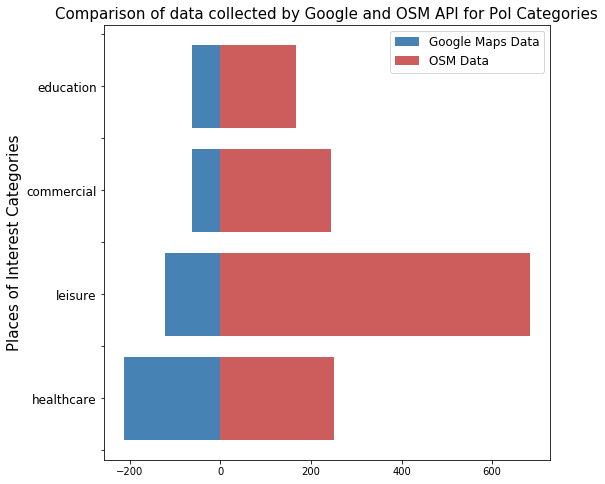

In [48]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
lis = ['','','healthcare','', 'leisure','', 'commercial','', 'education']
d = [1,2,3,4]
ax.barh(d, -(google_grp.values[-4:]),  color='steelblue', label='Google Maps Data')
ax.barh(d, osm_grp.values, color='indianred', label='OSM Data')
ax.set_ylabel('Places of Interest Categories', fontsize=15)
ax.set_title('Comparison of data collected by Google and OSM API for PoI Categories', fontsize=15)
ax.legend(loc='best', fontsize=12)
ax.set_yticklabels(lis, fontsize=12);

### Creating a dataframe for the common amenities data

In [49]:
odata1 = osm_data[osm_data.amenity.isin(['bank', 'cafe', 'dentist', 'hospital', 'pharmacy', 'restaurant',
       'school', 'university'])]

gdata1 = google_data[google_data.Entity_Type_1.isin(['bank', 'cafe', 'dentist', 'hospital', 'pharmacy', 'restaurant',
       'school', 'university'])]

odata_grp = odata1.groupby('amenity').count()['id']
gdata_grp = gdata1.groupby('Entity_Type_1').count()['Place_ID']

all_data = pd.DataFrame()
all_data['GoogleMaps_Data'] = gdata_grp
all_data['OSM_Data'] = odata_grp
all_data = all_data.set_index(odata_grp.index)

all_data

,GoogleMaps_Data,OSM_Data
amenity,,
bank,58,244
cafe,58,160
dentist,61,39
hospital,67,82
pharmacy,59,129
restaurant,46,523
school,51,127
university,2,39


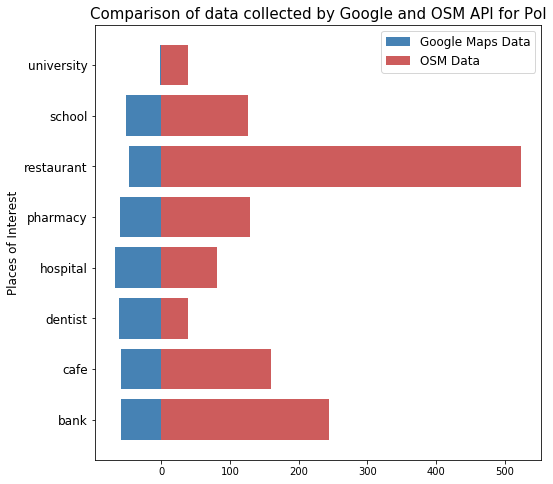

In [50]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
lis = ['']+all_data.index.tolist()
d = [i+1 for i in range(len(all_data))]
ax.barh(d, -(all_data.GoogleMaps_Data),  color='steelblue', label='Google Maps Data')
ax.barh(d, all_data.OSM_Data, color='indianred', label='OSM Data')
ax.set_ylabel('Places of Interest', fontsize=12)
ax.set_title('Comparison of data collected by Google and OSM API for PoI', fontsize=15)
ax.legend(loc='best', fontsize=12)
ax.set_yticklabels(lis, fontsize=12);